<hr>

## Spring 2020 

<hr>

<h3> Importing libraries and initializing variables </h3>

In [1]:
%matplotlib inline

import argparse
import glob
import math
import ntpath
import shutil
import random, os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import edfreader
import models
import mne
import pyeeg
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import optimizers, losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation, SpatialDropout1D, GlobalMaxPool1D
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



VBS = False  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 2020  # seed value for the random seeds
batch_size = 28

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# making string dictionary for the label values
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings 
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())  # finding the current project path in windows

Using TensorFlow backend.


<h3> Localizing fetch_data function to import all subjects </h3>

In [2]:
# localized fetch_data function by using mne library
# https://github.com/mne-tools/mne-python/blob/maint/0.20/mne/datasets/sleep_physionet/age.py#L18-L111
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

<h3> Reading input data </h3>

In [3]:
subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data 
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and 
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)  
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

<h3> Sampling data and saving the results in NPZ format </h3>

In [4]:
ch_labels = 'EEG Fpz-Cz'  # channels to be selected
data_frames = []
if VBS:
    print("Importing data into dataframes:")
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame(scaling_time=100.0)[ch_labels]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))
        
        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = edfreader.BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(item[1], 'r')
        annot_raw_read = edfreader.BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []
        
        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=np.int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x, 
            "y": y, 
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)

<h3> Plotting the first 20 subjects and saving the results in a PDF file </h3>

<Figure size 432x288 with 0 Axes>

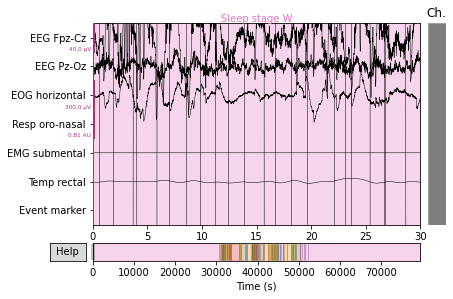

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


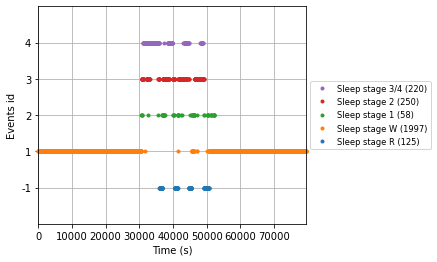

<Figure size 432x288 with 0 Axes>

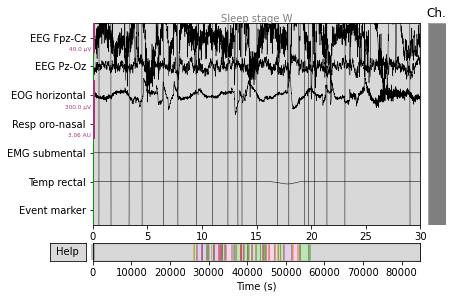

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


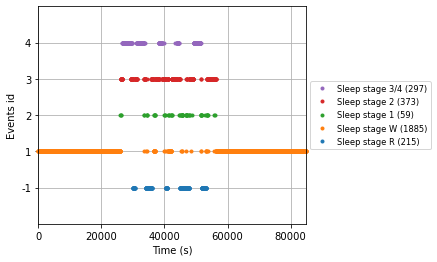

In [5]:
# plotting some of the subjects' raw signals and thier sleep stage
pdf_report = PdfPages('Sleep_Plots.pdf')
for item in tqdm(subject_files[:20]):
    raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
    annot_train = mne.read_annotations(item[1])

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)
    figure = plt.figure()
    figure.suptitle("Subject: " + str(item[0][-13:-11]) + ", Night: " + str(item[0][-11:-10]))
    pdf_report.savefig(figure, papertype='a0', bbox_inches='tight')
    pdf_report.savefig(raw_train.plot(duration=30), papertype='a0', bbox_inches='tight')

    annotation_desc_2_event_id = {'Sleep stage R': -1,
                                  'Sleep stage W': 1,
                                  'Sleep stage 1': 2,
                                  'Sleep stage 2': 3,
                                  'Sleep stage 3': 4,
                                  'Sleep stage 4': 4
    }

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage R'  : -1,
                'Sleep stage W'  : 1,
                'Sleep stage 1'  : 2,
                'Sleep stage 2'  : 3,
                'Sleep stage 3/4': 4
    }
    # plot events and saving them in PDF report
    pdf_report.savefig(mne.viz.plot_events(events_train, event_id=event_id,
                        sfreq=raw_train.info['sfreq']), bbox_inches='tight')
pdf_report.close()

<h3> Reading NPZ files for training dataset </h3>

In [6]:
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
train_val, test = train_test_split(npz_files, test_size=0.15, random_state=seed)
train, val = train_test_split(train_val, test_size=0.1, random_state=seed)

train_dict = {k: np.load(k) for k in train}
test_dict = {k: np.load(k) for k in test}
val_dict = {k: np.load(k) for k in val}

ids = sorted(list([x.split("\\")[-1][:5] for x in npz_files]))

In [7]:
X = np.zeros((0, 3000, 1))
y = []
for fn in tqdm(npz_files):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

In [8]:
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train.shape, X_test.shape))
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

X_train = np.squeeze(X_train, axis=(2,))
X_test = np.squeeze(X_test, axis=(2,))
X_val = np.squeeze(X_val, axis=(2,))

In [9]:
pp_X_train = np.array([models.butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([models.butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([models.butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])
pp_X_test = np.expand_dims(pp_X_test, axis=2)
pp_X_train = np.expand_dims(pp_X_train, axis=2)
pp_X_val = np.expand_dims(pp_X_val, axis=2)
print(pp_X_val.shape)


(17430, 3000, 1)


In [10]:
checkpoint = ModelCheckpoint("model_cps", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor="val_loss", mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
#     early,
    redonplat,
    csv_logger,
]

In [11]:
model_2019 = models.model_baseline_2019()
hist_19 = model_2019.fit(
    pp_X_train, y_train_, batch_size=64, epochs=5, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)


Epoch 00001: val_loss improved from -inf to 1.15586, saving model to model_cps
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_cps\assets

Epoch 00002: val_loss did not improve from 1.15586

Epoch 00003: val_loss did not improve from 1.15586

Epoch 00004: val_loss did not improve from 1.15586

Epoch 00005: val_loss did not improve from 1.15586

Epoch 00006: val_loss did not improve from 1.15586

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00007: val_loss did not improve from 1.15586

Epoch 00008: val_loss did not improve from 1.15586

Epoch 00009: val_loss did not improve from 1.15586

Epoch 00010: val_loss did not improve from 1.15586


In [12]:
y_pred = model_2019.predict(pp_X_test, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1 = f1_score(y_test, y_pred, average="macro")
print(">>> f1 score: {}".format(f1))
report = classification_report(y_test, y_pred)
print(report)

>>> f1 score: 0.33837048851074375
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      6453
           1       0.26      0.06      0.10      2183
           2       0.51      0.92      0.65      6877
           3       0.51      0.07      0.12      1230
           4       0.32      0.02      0.04      2623

    accuracy                           0.59     19366
   macro avg       0.48      0.37      0.34     19366
weighted avg       0.56      0.59      0.52     19366



In [13]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
prediction = dtree.predict(X_test)

print('With decision tree accuracy is: ',dtree.score(X_test,y_test)) # accuracy

With decision tree accuracy is:  0.37658783434885884


In [14]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
prediction = rf.predict(X_test)

print('With Random forest accuracy is: ',rf.score(X_test,y_test)) # accuracy

With Random forest accuracy is:  0.5364040070226169


In [15]:
# np.random.seed(seed)
# model = KerasClassifier(build_fn=create_model, epochs=250, batch_size=10, verbose=0)
# neurons_in = [16, 32]
# learn_rates_in = [0.001, 0.01]
# epochs_in = [200, 300]
# param_grid = dict(neurons=neurons_in, learn_rate=learn_rates_in, epochs=epochs_in)
# results_report = ['accuracy', 'precision', 'recall', 'f1']
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring=results_report, refit='accuracy',verbose=20)
# grid_result = grid.fit(X_train, y_train)